# 1. Importation des bibliothèques utiles

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
import time
from itertools import product
from tqdm import tqdm

# 2. Graines pour assurer la répétition de l'aléatoire

In [4]:
np.random.seed(42)
random.seed(42)

# 3. Définitions de quelques fonctions d'activation

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sine(x):
    return np.sin(x)

def hardlim(x):
    return np.where(x >= 0, 1, 0)

def tribas(x):
    return np.maximum(0, 1 - np.abs(x))

def radbas(x):
    return np.exp(-x**2)

def relu(x):
    return np.maximum(x, 0)


In [10]:
def activation_function(H, activF):
    if activF == 'sigmoid':
        return sigmoid(H)
    elif activF == 'sine':
        return sine(H)
    elif activF == 'hardlim':
        return hardlim(H)
    elif activF == 'tribas':
        return tribas(H)
    elif activF == 'radbas':
        return radbas(H)
    elif activF == 'relu':
        return relu(H)
    else:
        raise ValueError("Fonction d'activation non reconnue")

#  4. Fonction de corruption avec du bruit

In [13]:
def corrupt(X, gamma, dB):
    np.random.seed(20)  # Assurer que le bruit est le même à chaque fois
    bruit = np.random.normal(0, dB, X.shape)
    return X + gamma * bruit

# 5. Fonction de mise à l'échelle des données (Min-Max scaling)

In [16]:
def scaledata(data, min_val, max_val):
    if min_val == max_val:
        return data
    scaler = MinMaxScaler(feature_range=(min_val, max_val))
    return scaler.fit_transform(data)

# 6. Fonction de division des données en mini-batches

In [19]:
def divide_batches(inputs, outputs, batch_size):
    
    if isinstance(inputs, list) and isinstance(outputs, list):
        return inputs, outputs

    batches_inputs = []
    batches_outputs = []
    num_samples = inputs.shape[0]
    for i in range(0, num_samples, batch_size):
        batches_inputs.append(inputs[i:i+batch_size])
        batches_outputs.append(outputs[i:i+batch_size])
    return batches_inputs, batches_outputs

# 7. Fonction d'implémentation du modèle d'apprentissage DOS-ELM

In [22]:
def DOS_ELM(Trinputs, Tsinputs, Troutputs, Tsoutputs, Opts):

    #Training 
    start_train = time.time()
    mini_batch = Opts['mini_batch']
    activF = Opts['activF']
    Neurones = Opts['Neurones']
    mu = Opts['mu']
    lambdaMin = Opts['lambdaMin']
    gamma = Opts['gamma']
    dB = Opts['dB']

    if not isinstance(Trinputs, list):
        Trinputs, Troutputs = divide_batches(Trinputs, Troutputs, mini_batch)
    if not isinstance(Tsinputs, list):
        Tsinputs, Tsoutputs = divide_batches(Tsinputs, Tsoutputs, mini_batch)

    X_clean = Trinputs[0]
    T = Troutputs[0]
    X = corrupt(X_clean, gamma, dB)
    X = np.clip(X, 0, 1)
    Cr = [X]

    IW = np.random.rand(Neurones[0], X.shape[1])
    biais = np.random.rand(Neurones[0], 1)
    H_linear = IW @ X.T + biais
    H = activation_function(H_linear, activF)

    B_AE = np.linalg.pinv(H.T) @ X_clean
    B_OS = np.linalg.pinv(H.T) @ T

    P_AE = np.linalg.pinv(H @ H.T)
    P_OS = np.linalg.pinv(H @ H.T)

    reconstructed_X = scaledata(H.T @ B_AE, np.min(X_clean), np.max(X_clean))
    E = [X_clean - reconstructed_X]
    predicted_T = scaledata(H.T @ B_OS, np.min(T), np.max(T))
    En = [T - predicted_T]

    e_AE = [np.sqrt(mean_squared_error(E[0], np.zeros_like(E[0])))]
    e_OS = [np.sqrt(mean_squared_error(En[0], np.zeros_like(En[0])))]

    lambdas_AE = [lambdaMin]
    lambdas_OS = [lambdaMin]
    Index = []

    for t in range(1, len(Trinputs)):
        Xnew_clean = Trinputs[t]
        Xnew = corrupt(Xnew_clean, gamma, dB)
        Xnew = np.clip(Xnew, 0, 1) 
        Cr.append(Xnew)
        Tnew = Troutputs[t]
        Hnew_linear = np.linalg.pinv(B_AE.T) @ Xnew_clean.T 
        Hnew = activation_function(Hnew_linear, activF)

        reconstructed_X_new = scaledata(Hnew.T @ B_AE, np.min(Xnew_clean), np.max(Xnew_clean))
        E_current = Xnew - reconstructed_X_new
        E.append(E_current)

        predicted_T_new = scaledata(Hnew.T @ B_OS, np.min(Tnew), np.max(Tnew))
        En_current = Tnew - predicted_T_new
        En.append(En_current)

        e_AE_current = np.sqrt(mean_squared_error(E_current, np.zeros_like(E_current)))
        e_OS_current = np.sqrt(mean_squared_error(En_current, np.zeros_like(En_current)))
        
        e_AE.append(e_AE_current)
        e_OS.append(e_OS_current)

        lambda_AE = lambdas_AE[-1]
        lamdba_OS = lambdas_OS[-1]
        
        if e_OS_current > e_OS[t-1]:
            Index.append(t)
            lambda_AE = lambdaMin + (1 - lambdaMin) * np.exp(-mu * e_AE_current)
            lambda_OS = lambdaMin + (1 - lambdaMin) * np.exp(-mu * e_OS_current)
            lambda_AE = np.clip(lambda_AE, lambdaMin, 1)
            lambda_OS = np.clip(lambda_OS, lambdaMin, 1)
            
            eye_size = Hnew.shape[0]
            
            K_AE = np.linalg.inv(P_AE @ Hnew @ Hnew.T + lambda_AE * np.eye(eye_size)) @ P_AE @ Hnew
            K_OS = np.linalg.inv(P_OS @ Hnew @ Hnew.T + lambda_OS * np.eye(eye_size)) @ P_OS @ Hnew
            
            P_AE = (1 / lambda_AE) * (P_AE - (K_AE @ Hnew.T @ P_AE))
            P_OS = (1 / lambda_OS) * (P_OS - (K_OS @ Hnew.T @ P_OS))
            
            B_AE = B_AE + P_AE @ Hnew @ E_current
            B_OS = B_OS + P_OS @ Hnew @ En_current
        
        lambdas_AE.append(lambda_AE)
        lambdas_OS.append(lambda_OS)
        
    end_train = time.time()
    training_time = end_train - start_train
     
    #Évaluation sur les données d'entraînement
    
    Tr_predictions = []
    Tr_acc = []
    
    for t in range(len(Trinputs)):
        inp = Trinputs[t]
        H_t = np.linalg.pinv(B_AE.T) @ inp.T
        H_t = activation_function(H_t, activF)
        Troutputs_hat = scaledata(H_t.T @ B_OS, np.min(Troutputs[t]), np.max(Troutputs[t]))
        Tr_predictions.append(Troutputs_hat)
        acc = np.sqrt(mean_squared_error(Troutputs_hat, Troutputs[t]))
        Tr_acc.append(acc)
        
    trainingAccuracy = np.mean(Tr_acc)
    all_tr_predictions = np.vstack(Tr_predictions)

    #Évaluation sur les données de test
    Ts_predictions = []
    Ts_acc = []
    
    for t in range(len(Tsinputs)):
        inp = Tsinputs[t]
        H_t = np.linalg.pinv(B_AE.T) @ inp.T
        H_t = activation_function(H_t, activF)
        Tsoutputs_hat = scaledata(H_t.T @ B_OS, np.min(Tsoutputs[t]), np.max(Tsoutputs[t]))
        Ts_predictions.append(Tsoutputs_hat)
        acc = np.sqrt(mean_squared_error(Tsoutputs_hat, Tsoutputs[t]))
        Ts_acc.append(acc)
        
    testingAccuracy = np.mean(Ts_acc)
    all_ts_predictions = np.vstack(Ts_predictions)

    
    resultats = {
        'Tr_RMSE_mean': trainingAccuracy,
        'Ts_RMSE_mean': testingAccuracy,
        'Tr_predictions': all_tr_predictions,
        'Ts_predictions': all_ts_predictions,
        'lambdas_AE': lambdas_AE,
        'lambdas_OS': lambdas_OS,
        'e_AE': e_AE,
        'e_OS': e_OS,
        'Index': Index,
        'Cr': Cr,
        'training_time': training_time,
        'Matrice_des_poids_du_DAE': B_AE,
        'Matrice_des_poids_ELM' : B_OS
    }

    return resultats


 # 8. Application concrète sur le jeu de données C-MAPSS

 # a. Chargement et exploration du dataset (condition de panne FD001)

In [26]:
column_names = [
    "Identifiant", "Cycle", "Paramètre_opérationnel_1", "Paramètre_opérationnel_2", "Paramètre_opérationnel_3",
    "capteur_1", "capteur_2", "capteur_3", "capteur_4", "capteur_5",
    "capteur_6", "capteur_7", "capteur_8", "capteur_9", "capteur_10",
    "capteur_11", "capteur_12", "capteur_13", "capteur_14", "capteur_15",
    "capteur_16", "capteur_17", "capteur_18", "capteur_19", "capteur_20",
    "capteur_21"
]


train_data = pd.read_csv("train_FD004.txt", delim_whitespace=True, header=None, names=column_names)
test_data = pd.read_csv("test_FD004.txt", delim_whitespace=True, header=None, names=column_names)
rul_data = pd.read_csv("RUL_FD004.txt", delim_whitespace=True, header=None, names=["RUL"])


C:\Users\priva\AppData\Local\Temp\ipykernel_27840\737323486.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv("train_FD004.txt", delim_whitespace=True, header=None, names=column_names)
C:\Users\priva\AppData\Local\Temp\ipykernel_27840\737323486.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv("test_FD004.txt", delim_whitespace=True, header=None, names=column_names)
C:\Users\priva\AppData\Local\Temp\ipykernel_27840\737323486.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv("RUL_FD004.txt", delim_whitespace=True, header=None, names=["RUL"])


# b. Détails sur le train_data, test_data et rul_data

In [28]:
train_data

,Identifiant,Cycle,Paramètre_opérationnel_1,Paramètre_opérationnel_2,Paramètre_opérationnel_3,capteur_1,capteur_2,capteur_3,capteur_4,capteur_5,...,capteur_12,capteur_13,capteur_14,capteur_15,capteur_16,capteur_17,capteur_18,capteur_19,capteur_20,capteur_21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774


In [29]:
test_data

,Identifiant,Cycle,Paramètre_opérationnel_1,Paramètre_opérationnel_2,Paramètre_opérationnel_3,capteur_1,capteur_2,capteur_3,capteur_4,capteur_5,...,capteur_12,capteur_13,capteur_14,capteur_15,capteur_16,capteur_17,capteur_18,capteur_19,capteur_20,capteur_21
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,130.87,2388.50,8112.61,9.4427,0.02,331,2212,100.00,10.53,6.2620
41210,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,314.51,2388.33,8086.83,9.2772,0.02,366,2324,100.00,24.33,14.6486
41211,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,182.76,2388.64,8100.84,9.3982,0.02,336,2223,100.00,14.69,8.8389
41212,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,314.17,2388.37,8085.24,9.2727,0.03,366,2324,100.00,24.44,14.6887


In [31]:
rul_data

,RUL
0,22
1,39
2,107
3,75
4,149
...,...
243,35
244,131
245,194
246,112


# c. Sélection des colonnes pertinentes et normalisation

In [36]:
train_data_norm = train_data.copy()
test_data_norm = test_data.copy()

#sélection
train_int = train_data_norm.drop(columns=['Identifiant', 'Cycle'])

constant_cols = [col for col in train_int.columns if train_int[col].nunique() == 1]

selected_cols = [col for col in train_int.columns if col not in constant_cols]

#normalisation
scaler = MinMaxScaler(feature_range=(0, 1))

train_data_norm[selected_cols] = scaler.fit_transform(train_data_norm[selected_cols])
test_data_norm[selected_cols] = scaler.transform(test_data_norm[selected_cols])

train_data_norm = train_data_norm.drop(columns=['Identifiant', 'Cycle'] + constant_cols)
test_data_norm = test_data_norm.drop(columns=['Identifiant', 'Cycle'] + constant_cols)

# Vérification
print("Colonnes restantes dans train_data :", train_data_norm.columns.tolist())
print("Colonnes restantes dans test_data :", test_data_norm.columns.tolist())


Colonnes restantes dans train_data : ['Paramètre_opérationnel_1', 'Paramètre_opérationnel_2', 'Paramètre_opérationnel_3', 'capteur_1', 'capteur_2', 'capteur_3', 'capteur_4', 'capteur_5', 'capteur_6', 'capteur_7', 'capteur_8', 'capteur_9', 'capteur_10', 'capteur_11', 'capteur_12', 'capteur_13', 'capteur_14', 'capteur_15', 'capteur_16', 'capteur_17', 'capteur_18', 'capteur_19', 'capteur_20', 'capteur_21']
Colonnes restantes dans test_data : ['Paramètre_opérationnel_1', 'Paramètre_opérationnel_2', 'Paramètre_opérationnel_3', 'capteur_1', 'capteur_2', 'capteur_3', 'capteur_4', 'capteur_5', 'capteur_6', 'capteur_7', 'capteur_8', 'capteur_9', 'capteur_10', 'capteur_11', 'capteur_12', 'capteur_13', 'capteur_14', 'capteur_15', 'capteur_16', 'capteur_17', 'capteur_18', 'capteur_19', 'capteur_20', 'capteur_21']


# d. Détails sur les données d'entraînement normalisées

In [39]:
train_data_norm

,Paramètre_opérationnel_1,Paramètre_opérationnel_2,Paramètre_opérationnel_3,capteur_1,capteur_2,capteur_3,capteur_4,capteur_5,capteur_6,capteur_7,...,capteur_12,capteur_13,capteur_14,capteur_15,capteur_16,capteur_17,capteur_18,capteur_19,capteur_20,capteur_21
0,0.999926,0.997625,1.0,0.000000,0.130347,0.272082,0.212586,0.000000,0.001882,0.002738,...,0.003593,0.993111,0.550773,0.400540,0.0,0.288660,0.627907,1.0,0.015473,0.015881
1,0.476147,0.831591,1.0,0.626985,0.647971,0.634407,0.511781,0.507937,0.498118,0.450787,...,0.450364,0.992395,0.481761,0.351346,0.0,0.608247,0.864693,1.0,0.477968,0.481487
2,0.999900,0.998694,1.0,0.000000,0.123646,0.271245,0.222481,0.000000,0.001255,0.004625,...,0.003202,0.993056,0.531031,0.423787,0.0,0.278351,0.627907,1.0,0.010764,0.018932
3,0.999810,0.997625,1.0,0.000000,0.121351,0.266168,0.224835,0.000000,0.001882,0.004164,...,0.003641,0.993194,0.553707,0.401716,0.0,0.268041,0.627907,1.0,0.012782,0.018724
4,0.595275,0.737173,0.0,0.238089,0.005691,0.033916,0.022025,0.293184,0.208908,0.088924,...,0.087492,0.001405,0.048140,0.920536,0.0,0.030928,0.000000,0.0,0.130172,0.145560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,0.238045,0.296912,1.0,0.597937,0.641179,0.739044,0.698595,0.617180,0.614178,0.617569,...,0.615499,0.995150,0.817347,0.096312,1.0,0.721649,0.854123,1.0,0.637403,0.642614
61245,0.000067,0.001781,1.0,1.000000,0.990821,0.961980,0.966374,1.000000,0.997491,0.992592,...,0.993964,0.994406,0.816818,0.016052,1.0,0.969072,1.000000,1.0,0.982846,0.990444
61246,0.000069,0.000000,1.0,1.000000,0.993207,0.985742,0.975477,1.000000,0.997491,0.995928,...,0.994917,0.994462,0.837185,0.026569,1.0,0.958763,1.000000,1.0,0.996300,0.996731
61247,0.833284,0.997625,1.0,0.060269,0.186249,0.374315,0.297250,0.146592,0.143664,0.146696,...,0.145682,0.995426,0.672951,0.302982,0.0,0.360825,0.651163,1.0,0.171544,0.168143


In [41]:
test_data_norm

,Paramètre_opérationnel_1,Paramètre_opérationnel_2,Paramètre_opérationnel_3,capteur_1,capteur_2,capteur_3,capteur_4,capteur_5,capteur_6,capteur_7,...,capteur_12,capteur_13,capteur_14,capteur_15,capteur_16,capteur_17,capteur_18,capteur_19,capteur_20,capteur_21
0,0.476271,0.831354,1.0,0.626985,0.653479,0.643669,0.488507,0.507937,0.497491,0.451753,...,0.451439,0.992533,0.488614,0.362278,0.0,0.618557,0.864693,1.0,0.475950,0.484043
1,0.595087,0.736342,0.0,0.238089,0.006793,0.036454,0.016957,0.293184,0.208908,0.088096,...,0.086270,0.001433,0.042513,0.929738,0.0,0.041237,0.000000,0.0,0.141271,0.139909
2,0.999810,1.000000,1.0,0.000000,0.126216,0.263171,0.195653,0.000000,0.001255,0.002692,...,0.004081,0.993001,0.541876,0.422161,0.0,0.268041,0.627907,1.0,0.007736,0.019786
3,0.999893,0.997862,1.0,0.000000,0.125849,0.262010,0.198967,0.000000,0.001255,0.002439,...,0.002859,0.992863,0.560536,0.409500,0.0,0.268041,0.627907,1.0,0.013454,0.008561
4,0.833363,0.997625,1.0,0.060269,0.180099,0.298031,0.224282,0.146592,0.144291,0.130614,...,0.130774,0.992781,0.509895,0.389988,0.0,0.319588,0.651163,1.0,0.157753,0.160009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,0.999788,0.997743,1.0,0.000000,0.136038,0.328707,0.251591,0.000000,0.003137,0.004993,...,0.006256,0.994517,0.641619,0.438317,0.0,0.298969,0.627907,1.0,0.012445,0.009983
41210,0.476162,0.831948,1.0,0.626985,0.665688,0.680690,0.567936,0.507937,0.501255,0.456884,...,0.455056,0.994048,0.579628,0.381063,0.0,0.659794,0.864693,1.0,0.476623,0.481116
41211,0.833146,0.999169,1.0,0.060269,0.187626,0.345584,0.255914,0.146592,0.146173,0.135169,...,0.133071,0.994902,0.613317,0.422923,0.0,0.350515,0.651163,1.0,0.152371,0.154745
41212,0.476164,0.831354,1.0,0.626985,0.667432,0.665461,0.556815,0.507937,0.501255,0.453203,...,0.454226,0.994158,0.575805,0.379506,1.0,0.659794,0.864693,1.0,0.480323,0.483369


# e. Modèle de dégradation linéaire

# e.1 Pour le training

In [45]:
train_data["RUL_train"] = train_data.groupby("Identifiant")["Cycle"].transform(lambda x: x.max() - x)
y_train = train_data["RUL_train"]
train_data = train_data.drop(columns=["RUL_train"])

In [47]:
y_train

0        320
1        319
2        318
3        317
4        316
        ... 
61244      4
61245      3
61246      2
61247      1
61248      0
Name: RUL_train, Length: 61249, dtype: int64

# e.2 Pour le testing

In [50]:

rul_int = rul_data.copy()
rul_int["Identifiant"] = rul_int.index + 1  


max_cycle_by_unit = test_data.groupby("Identifiant")["Cycle"].max().reset_index()
max_cycle_by_unit = max_cycle_by_unit.rename(columns={"Cycle": "max_cycle"})


lookup = pd.merge(rul_int, max_cycle_by_unit, on="Identifiant", how="left")
lookup["total_cycle"] = lookup["max_cycle"] + lookup["RUL"]


temp = pd.merge(test_data, lookup[["Identifiant", "total_cycle"]], on="Identifiant", how="left")

temp["RUL_test"] = temp["total_cycle"] - temp["Cycle"]

rul_data_comp = temp[["RUL_test"]].reset_index(drop=True)

In [52]:
y_test = rul_data_comp

In [54]:
y_test

,RUL_test
0,251
1,250
2,249
3,248
4,247
...,...
41209,30
41210,29
41211,28
41212,27


# f. Normalisation des données de sortie y_train et y_test (RUL)

In [57]:

if isinstance(y_train, (pd.Series, pd.DataFrame)):
    y_train_arr = y_train.values.reshape(-1, 1)
else:
    y_train_arr = np.array(y_train).reshape(-1, 1)

if isinstance(y_test, (pd.Series, pd.DataFrame)):
    y_test_arr = y_test.values.reshape(-1, 1)
else:
    y_test_arr = np.array(y_test).reshape(-1, 1)


scaler_y = MinMaxScaler(feature_range=(0, 1))

y_train_norm = scaler_y.fit_transform(y_train_arr)
y_test_norm = scaler_y.transform(y_test_arr)


In [59]:
y_train_norm

array([[0.5904059 ],
       [0.58856089],
       [0.58671587],
       ...,
       [0.00369004],
       [0.00184502],
       [0.        ]])

In [61]:
y_test_norm

array([[0.46309963],
       [0.46125461],
       [0.45940959],
       ...,
       [0.05166052],
       [0.0498155 ],
       [0.04797048]])

# g. Division en mini-batchs

In [64]:

X_train_array = train_data_norm.values
X_test_array = test_data_norm.values


y_train_array = y_train_norm 
y_test_array = y_test_norm

# Diviser les données d'entraînement en mini-batches
mini_batch = 16 
X_train_batches, y_train_batches = divide_batches(X_train_array, y_train_array, mini_batch)
X_test_batches, y_test_batches = divide_batches(X_test_array, y_test_array, mini_batch)

print("Nombre de mini-batchs pour l'entraînement :", len(X_train_batches))
print("Taille du premier mini-batch :", X_train_batches[0].shape)


Nombre de mini-batchs pour l'entraînement : 3829
Taille du premier mini-batch : (16, 24)


# h. Entrainement du modèle

In [67]:
# Paramètres d'entraînement du modèle DOS-ELM
Opts = {
    'mini_batch': mini_batch,     # Taille du mini-batch 
    'activF': 'relu',             # Fonction d'activation choisie
    'Neurones': [256],            # Nombre de neurones dans la couche cachée
    'mu': 0.1,                  # Paramètre de mise à jour (pour le facteur d'oubli dynamique)
    'lambdaMin': 0.1,             # Valeur minimale du facteur d'oubli 
    'gamma': 0.1,                 # Ratio de bruit utilisé pour la corruption
    'dB': 10                      # Niveau de bruit (écart-type)
}


model = DOS_ELM(X_train_batches, X_test_batches, y_train_batches, y_test_batches, Opts)

# Affichage des performances obtenues
print("RMSE sur l'ensemble d'entraînement :", model['Tr_RMSE_mean'])
print("RMSE sur l'ensemble de test :", model['Ts_RMSE_mean'])


RMSE sur l'ensemble d'entraînement : 0.029606219361324248
RMSE sur l'ensemble de test : 0.029383932259477615


# i. Évaluation sur les données de test

In [69]:

y_test_pred = scaler_y.inverse_transform(model['Ts_predictions'])
y_test_actual = scaler_y.inverse_transform(y_test_norm)

y_test_pred = y_test_pred.flatten()
y_test_actual = y_test_actual.flatten()


In [70]:
y_test_actual

array([251., 250., 249., ...,  28.,  27.,  26.])

In [71]:
y_test_pred

array([243.82224364, 246.34657146, 250.98316071, ...,  38.21286912,
        32.93886247,  38.17093621])

In [72]:
def coef_determination(y, pred):
    u = ((y-pred)**2).sum()
    v = ((y - y.mean())**2).sum()
    return (1 - u/v)

In [73]:
print('MAE :', mean_absolute_error(y_test_actual, y_test_pred))
print('MSE :', mean_squared_error(y_test_actual, y_test_pred))
print('RMSE :', np.sqrt(mean_squared_error(y_test_actual, y_test_pred))) #pour remettre à l'échelle la MSE qui sont des valeurs au carrés
print('MAE :', median_absolute_error(y_test_actual, y_test_pred))

MAE : 13.028973250939051
MSE : 1345.8989621797293
RMSE : 36.686495637764715
MAE : 5.9713266495377795


In [74]:
coef_determination(y_test_actual, y_test_pred)

0.8415639409453654

# j. Évaluation sur les données d'entraînement

In [76]:
y_train = np.array(y_train).reshape(-1, 1).flatten()
y_pred_tr=scaler_y.inverse_transform(model['Tr_predictions']).flatten()

In [77]:
y_train

array([320, 319, 318, ...,   2,   1,   0], dtype=int64)

In [78]:
y_pred_tr

array([3.19977232e+02, 3.14993260e+02, 3.19982269e+02, ...,
       1.13246724e+00, 1.49683381e+01, 8.36407798e-05])

In [79]:
print('MAE :', mean_absolute_error(y_train, y_pred_tr))
print('MSE :', mean_squared_error(y_train, y_pred_tr))
print('RMSE :', np.sqrt(mean_squared_error(y_train, y_pred_tr))) #pour remettre à l'échelle la MSE qui sont des valeurs au carrés
print('MAE :', median_absolute_error(y_train, y_pred_tr))

MAE : 13.023419388169048
MSE : 1567.4307633156861
RMSE : 39.590791395420304
MAE : 5.942777404037827


In [80]:
coef_determination(y_train, y_pred_tr)

0.8055520073815919

# k. Temps d'entraînement

In [82]:
model['training_time']

108.57814335823059

# l. Vérification Stratégie USS

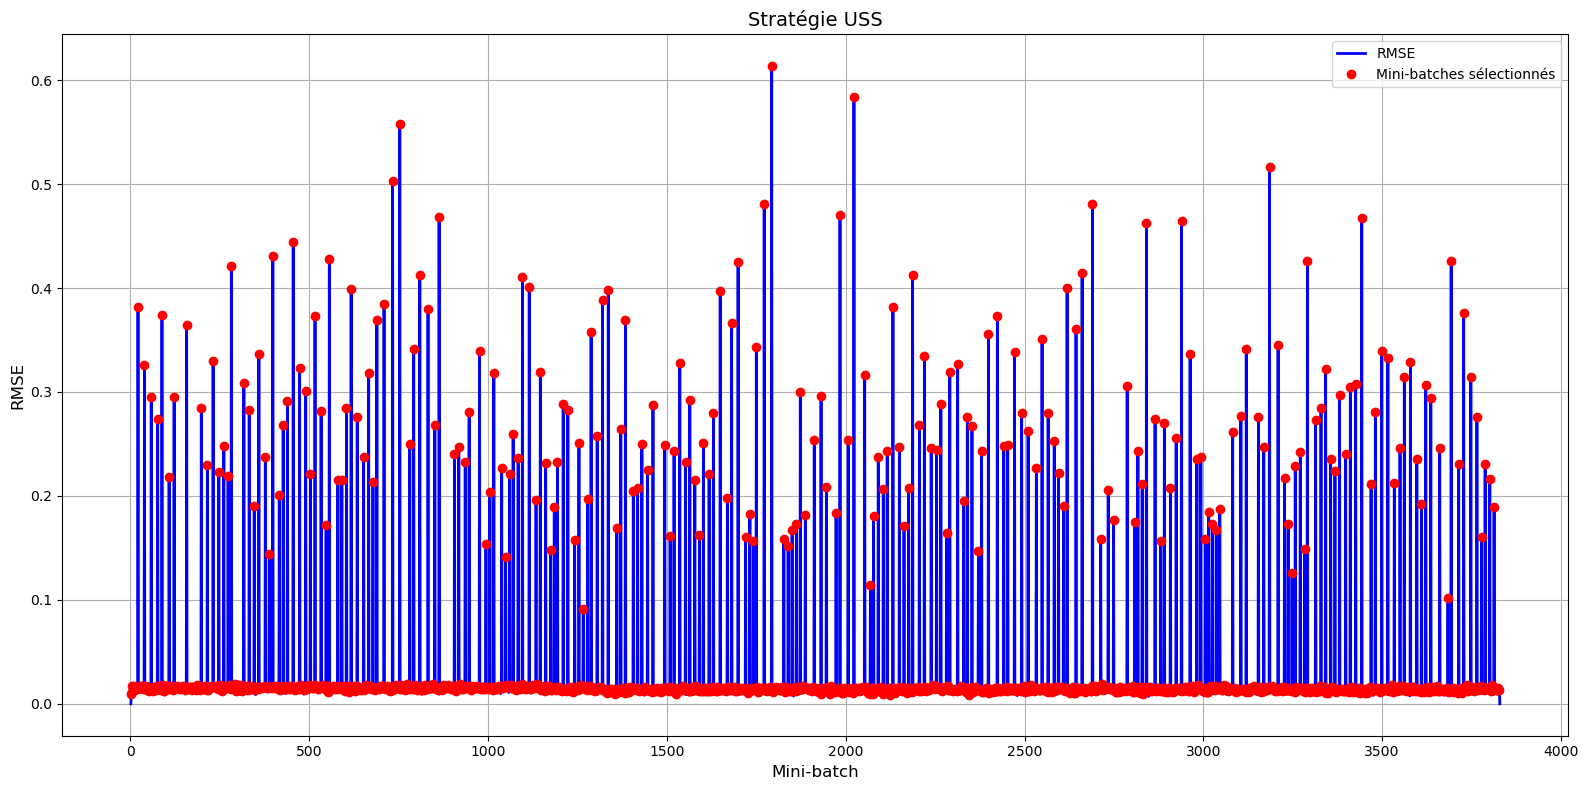

In [84]:
# Vérification globale

e_OS = model['e_OS']
Index = model['Index']

mini_batches = np.arange(1, len(e_OS) + 1)
rmse = e_OS


plt.figure(figsize=(16, 8))
plt.plot(mini_batches, rmse, 'b-', linewidth=2, label='RMSE')
plt.plot(np.array(Index) + 1, [rmse[i] for i in Index], 'ro', label='Mini-batches sélectionnés')  


plt.xlabel('Mini-batch', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Stratégie USS', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Affichage
plt.show()


In [101]:
len(model['Index'])

1958

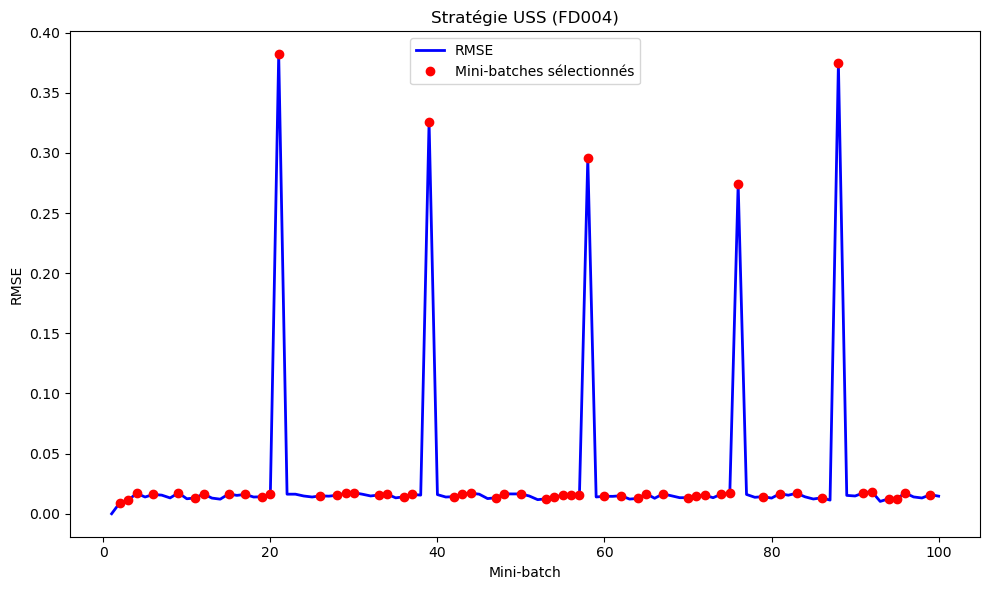

In [103]:
#Vérification sur un sous-ensemble

rmse = model['e_OS']
subset = 100 


mini_batches = np.arange(1, subset + 1)
rmse_subset = rmse[:subset]
index_subset = [i for i in model['Index'] if i < subset]


plt.figure(figsize=(10, 6))
plt.plot(mini_batches, rmse_subset, 'b-', linewidth=2, label='RMSE')
plt.plot([i + 1 for i in index_subset], [rmse[i] for i in index_subset], 'ro', label='Mini-batches sélectionnés')
plt.xlabel('Mini-batch')
plt.ylabel('RMSE')
plt.title('Stratégie USS (FD004)' )
plt.legend()
plt.tight_layout()
plt.savefig('Stratégie_USS_FD004')
plt.show()


# m. Tracé des graphiques comparatifs RUL-Prédictions du DOS-ELM

# m.1 Sur les données cibles d'entraînement

In [705]:
def targets_train(data_length, early_rul = None):
    # on définit early_rul si on veut une RUl par morceaux de durée early_rul - data_length
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:    
            targets = np.arange(data_length-1, -1, -1)
            return targets
        else:
            targets = np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
            return targets


In [707]:
np.unique(train_data['Identifiant'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [709]:
num_cycles_to_failure = train_data.groupby("Identifiant")["Cycle"].count()
print(num_cycles_to_failure.values)

[192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
 158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
 170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
 193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
 213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
 135 341 155 258 283 336 202 156 185 200]


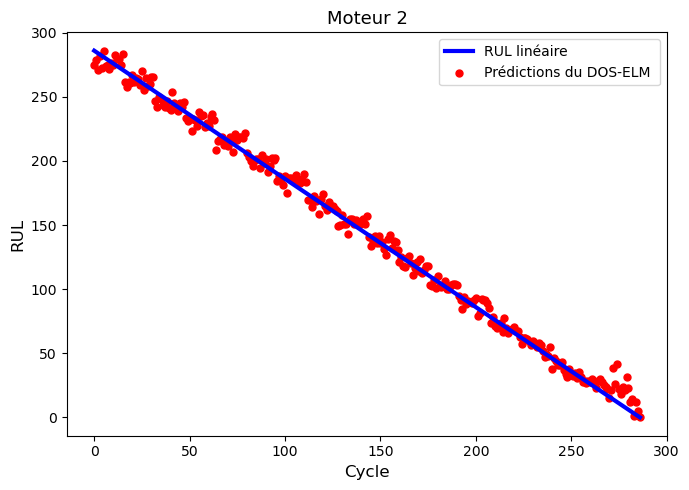

In [711]:
n_cycles = 287
moteur_rul = targets_train(n_cycles, early_rul=None)  


moteur_indices = train_data[train_data['Identifiant'] == 2].index.tolist()
moteur_pred = y_pred_tr[engine_indices]


plt.figure(figsize=(7, 5))
plt.plot(range(n_cycles), moteur_rul, label="RUL linéaire", linewidth=3, color="blue")
plt.scatter(range(n_cycles), moteur_pred, label="Prédictions du DOS-ELM ", color="red", s=25)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("RUL", fontsize=12)
plt.title("Moteur 2", fontsize=13)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.savefig('train_dos_FD001')
plt.show()


# m.2 Sur les données cibles de test

In [714]:
def targets_test(data_length, early_rul=None):
    
    targets = np.arange(data_length - 1, -1, -1)
    
    if early_rul is not None:
        cutoff_index = np.argmax(targets < early_rul)
        return targets[:cutoff_index]
    
    return targets


In [716]:
np.unique(test_data['Identifiant'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [718]:
num_cycles_to_failure = test_data.groupby("Identifiant")["Cycle"].count()
print(num_cycles_to_failure.values)

[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [720]:
real_rul = num_cycles_to_failure.values + rul_data.values.flatten()
real_rul

array([143, 147, 195, 188, 189, 198, 251, 261, 166, 288, 180, 341, 290,
       153, 159, 197, 215, 161, 222, 200, 205, 150, 243, 206, 193, 195,
       206, 255, 261, 258, 204, 193, 156, 210, 209, 145, 142, 175, 179,
       161, 141, 166, 231, 163, 266, 193, 208, 170, 324, 153, 258, 218,
       190, 218, 250, 151, 263, 213, 208, 247, 180, 286, 227, 196, 199,
       161, 148, 195, 175, 246, 186, 181, 243, 263, 201, 215, 196, 179,
       164, 223, 221, 171, 210, 230, 152, 199, 172, 183, 313, 174, 272,
       170, 329, 188, 217, 234, 216, 180, 214, 218], dtype=int64)

In [722]:
rul_data.values.flatten()

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int64)

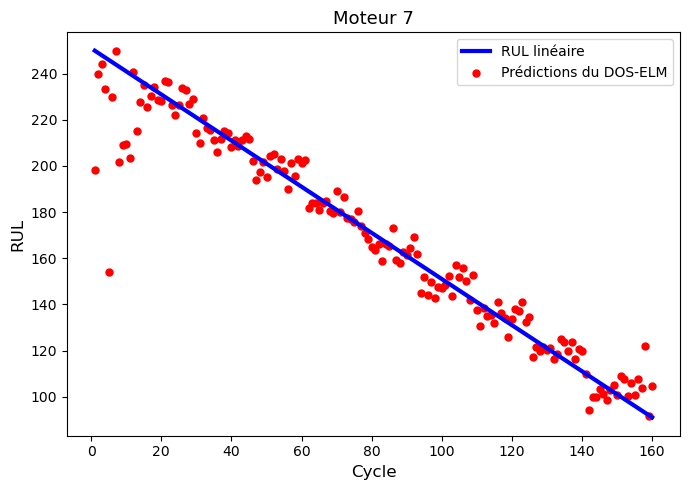

In [724]:

n_cycles_total = 251 #real_rul

moteur_rul = targets_test(n_cycles_total, early_rul=91)  #early_rul avec rul_data


moteur_indices = test_data[test_data['Identifiant'] == 7].index.tolist()
moteur_pred = y_test_pred[moteur_indices]

n_cycles = 160 #num_cycles_to_failure


# Tracé
plt.figure(figsize=(7, 5))
plt.plot(range(1,n_cycles+1), moteur_rul, label="RUL linéaire", linewidth=3, color="blue")
plt.scatter(range(1,n_cycles+1), moteur_pred, label="Prédictions du DOS-ELM", color="red", s=25)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("RUL", fontsize=12)
plt.title("Moteur 7", fontsize=13)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.savefig('test_dos_FD001')
plt.show()

# n. GridSearch

In [579]:
                            
param_grid = {
    'Neurones': [16, 32, 64, 128],
    'mu': [0.1, 0.05, 0.01, 0.005, 0.001],
    'gamma': [0.1, 0.2, 0.3],
    'dB': [5, 10, 15],
    'activF': ['relu'],
    'lambdaMin': [0.0001, 0.001, 0.01, 0.1]
}

# Générer toutes les combinaisons possibles
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

best_rmse = float('inf')
best_params = None
best_model = None
errors = []  # Liste pour stocker les erreurs

# Ajouter la barre de progression avec tqdm
for params in tqdm(param_combinations, desc="Grid Search Progress", ncols=100):
    Opts = {
        'mini_batch': mini_batch,  # Taille du mini-batch
        'activF': params['activF'],
        'Neurones': [params['Neurones']],  # En liste comme requis par ton modèle
        'mu': params['mu'],
        'lambdaMin': params['lambdaMin'],
        'gamma': params['gamma'],
        'dB': params['dB']
    }
    
    try:
        model = DOS_ELM(X_train_batches, X_test_batches, y_train_batches, y_test_batches, Opts)
        rmse = model['Ts_RMSE']
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_model = model
            
    except Exception as e:
        errors.append({'params': params, 'error': str(e)})

print("Meilleurs paramètres trouvés :", best_params)
print("Meilleur RMSE obtenu :", best_rmse)

# Affichage optionnel des erreurs
if errors:
    print(f"\n{len(errors)} erreurs rencontrées pendant la Grid Search :")
    for err in errors:
        print(f"Params : {err['params']} --> Erreur : {err['error']}")


Grid Search Progress: 100%|█████████████████████████████████████| 720/720 [1:40:27<00:00,  8.37s/it]

Meilleurs paramètres trouvés : None
Meilleur RMSE obtenu : inf

720 erreurs rencontrées pendant la Grid Search :
Params : {'Neurones': 16, 'mu': 0.1, 'gamma': 0.1, 'dB': 5, 'activF': 'relu', 'lambdaMin': 0.0001} --> Erreur : 'Ts_RMSE'
Params : {'Neurones': 16, 'mu': 0.1, 'gamma': 0.1, 'dB': 5, 'activF': 'relu', 'lambdaMin': 0.001} --> Erreur : 'Ts_RMSE'
Params : {'Neurones': 16, 'mu': 0.1, 'gamma': 0.1, 'dB': 5, 'activF': 'relu', 'lambdaMin': 0.01} --> Erreur : 'Ts_RMSE'
Params : {'Neurones': 16, 'mu': 0.1, 'gamma': 0.1, 'dB': 5, 'activF': 'relu', 'lambdaMin': 0.1} --> Erreur : 'Ts_RMSE'
Params : {'Neurones': 16, 'mu': 0.1, 'gamma': 0.1, 'dB': 10, 'activF': 'relu', 'lambdaMin': 0.0001} --> Erreur : 'Ts_RMSE'
Params : {'Neurones': 16, 'mu': 0.1, 'gamma': 0.1, 'dB': 10, 'activF': 'relu', 'lambdaMin': 0.001} --> Erreur : 'Ts_RMSE'
Params : {'Neurones': 16, 'mu': 0.1, 'gamma': 0.1, 'dB': 10, 'activF': 'relu', 'lambdaMin': 0.01} --> Erreur : 'Ts_RMSE'
Params : {'Neurones': 16, 'mu': 0.1, 'g

In [ ]:
param_grid = {
    'Neurons': [16, 32, 64, 128],
    'mu': [0.1, 0.05, 0.01, 0.005, 0.001],
    'N_ratio': [0.1, 0.2, 0.3],
    'dB': [5, 10, 15],
    'activF': ['relu'],
    'lamdaMin': [0.0001, 0.001, 0.01, 0.1]
}

param_grid = { 
    'Neurons': [64, 96, 128, 160],
    'mu': [0.008, 0.01, 0.012],
    'N_ratio': [0.1, 0.2, 0.3, 0.4],
    'dB': [0, 5, 10, 15],
    'activF': ['relu'],
    'lamdaMin': [0.0001, 0.0005, 0.001, 0.005, 0.01]
}

param_grid = {
    'Neurons': [32, 64],
    'mu': [0.01, 0.001],
    'N_ratio': [0.1, 0.2],
    'dB': [10],  # valeur médiane typique
    'activF': ['relu'],
    'lamdaMin': [0.001, 0.01]
}